In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [11]:

# # concatenate all data tables into one
# df_uhw = pd.read_csv('data_tables/uhw_data.csv')
# df_medway = pd.read_csv('data_tables/MFT_data.csv')
# df_lus = pd.read_csv('data_tables/LUS_data.csv')
# df_lus = df_lus.drop(columns=['Read Error'], errors='ignore')  # drop Read Error column if it exists
# df_all = pd.concat([df_uhw, df_medway, df_lus], ignore_index=True)

# # remove final column if it is unnamed
# if 'Unnamed: 0' in df_all.columns:
#     df_all = df_all.drop(columns=['Unnamed: 0'])
    
# df_all.to_csv('data_tables/all_data.csv', index=False)




In [2]:
def crop_mft_videos(frame, video_path):
    crop_coords_df = pd.read_csv('mft_video_crop_coordinates.csv')

    for index, row in crop_coords_df.iterrows():
        if row['video_path'] in video_path:
            x_1, y_1, x_2, y_2 = row['x_start'], row['y_start'], row['x_end'], row['y_end']
            scan_area_cropped = frame[y_1:y_2, x_1:x_2]
            return scan_area_cropped

In [3]:
def crop_jcuh_videos(frame):
    cropped_scan_area = frame[60:520, 300:620]
    return cropped_scan_area

In [4]:
def crop_uhw_videos(frame, rel_x=0.2938, rel_y=0.1917, rel_w=0.4125, rel_h=0.8083):
    height, width, channels = frame.shape
    x = int(rel_x * width)
    y = int(rel_y * height)
    w = int(rel_w * width)
    h = int(rel_h * height)
    scan_area_cropped = frame[y:y+h, x:x+w]
    return scan_area_cropped

In [5]:
def crop_frame(frame, video_path):
    if 'MFT' in video_path:
        return crop_mft_videos(frame, video_path)
    elif 'JCUH' in video_path:
        return crop_jcuh_videos(frame)
    elif 'UHW' in video_path:
        return crop_uhw_videos(frame)
    else:
        return frame  # return original frame if no cropping rules apply

In [3]:
#  extract 5 frames per second from each video
def extract_frames( video_path, data_frame, fps=5):

    # only extract frames for videos in data_frame where column 'neglect' is not True    
    if 'no_score' in data_frame.columns:
        video_record = data_frame[data_frame['File Path'] == video_path]
        if not video_record.empty and video_record.iloc[0]['no_score'] == True:
            return []
        
    if 'M-mode scan' in data_frame.columns:
        video_record = data_frame[data_frame['File Path'] == video_path]
        if not video_record.empty and video_record.iloc[0]['M-mode scan'] == True:
            return []
        
    # select videos with with is_duplicate == True only if preferred_duplicate == True
    if 'is_duplicate' in data_frame.columns and 'preferred_duplicate' in data_frame.columns:
        video_record = data_frame[data_frame['File Path'] == video_path]
        if not video_record.empty:
            if video_record.iloc[0]['is_duplicate'] == True and video_record.iloc[0]['preferred_duplicate'] == False:
                return []

    import cv2
    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / video_fps

    if duration <2.0:
        fps = 10
        
    frame_interval = int(video_fps / fps)
    frames = []
    frame_count = 0

    

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = crop_frame(frame, video_path)
        # resize frame to 300x450
        frame = cv2.resize(frame, (300, 450))
        if frame_count % frame_interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

In [7]:
#  save extracted frames to disk
def save_frames(frames, output_dir, base_filename):
    import cv2
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for i, frame in enumerate(frames):
        frame_filename = os.path.join(output_dir, f"{base_filename}_frame_{i:04d}.png")
        cv2.imwrite(frame_filename, frame)          

In [12]:
from tqdm import tqdm
# create data frame from first 10 rows of all_data.csv
df_all = pd.read_csv('data_tables/all_data.csv')
# only do it for whishaw videos
df_sample = df_all[df_all['Hospital'] == 'MFT']

# extract and save frames for each video in the sample data frame
for index, row in tqdm(df_sample.iterrows(), total=df_sample.shape[0]):
    video_path = row['File Path']
    frames = extract_frames(video_path, df_sample, fps=5)

    # Extract metadata from the row
    patient_id = row['Patient ID'] if 'Patient ID' in row else 'unknown'
    scan_no = row['Scan No'] if 'Scan No' in row else 'unknown'
    scan_label = row['Scan Label'] if 'Scan Label' in row else 'unknown'

    # Create filename with metadata
    base_filename = f"{patient_id}_{scan_no}_{scan_label}"
    output_dir = '/cosma5/data/durham/dc-fras4/ultrasound/output_frames/MFT'
    save_frames(frames, output_dir, base_filename)

  0%|          | 0/1744 [00:00<?, ?it/s]

100%|██████████| 1744/1744 [2:17:27<00:00,  4.73s/it]  


In [2]:
# out of all video frames select 10 based on variance criteria
def select_representative_frames(frames, num_frames=10):
    import numpy as np

    if len(frames) <= num_frames:
        return frames

    frame_variances = [np.var(frame) for frame in frames]
    sorted_indices = np.argsort(frame_variances)
    
    # select frames with highest variances
    selected_indices = sorted_indices[-num_frames:]
    selected_frames = [frames[i] for i in selected_indices]
    return selected_frames

In [3]:
# select 10 frames based on 10 most similar frame variances
def select_similar_variance_frames(frames, num_frames=10):
    import numpy as np
    from sklearn.metrics import pairwise_distances

    if len(frames) <= num_frames:
        return frames

    frame_variances = np.array([np.var(frame) for frame in frames]).reshape(-1, 1)
    distance_matrix = pairwise_distances(frame_variances)

    avg_distances = distance_matrix.mean(axis=1)
    sorted_indices = np.argsort(avg_distances)
    
    selected_indices = sorted_indices[:num_frames]
    selected_frames = [frames[i] for i in selected_indices]
    return selected_frames

In [16]:
dir = '/cosma5/data/durham/dc-fras4/ultrasound/output_frames/MFT'

# select all frames that start with YOUNG-SCAN-4
selected_frames = []
for filename in os.listdir(dir):
    if filename.startswith('1_LUS_1_LPB') and filename.endswith('.png'):
        filepath = os.path.join(dir, filename)
        frame = cv2.imread(filepath)
        selected_frames.append(frame)

    

In [17]:
select_frames_1 = select_representative_frames(selected_frames, num_frames=10)
select_frames_2 = select_similar_variance_frames(selected_frames, num_frames=10)



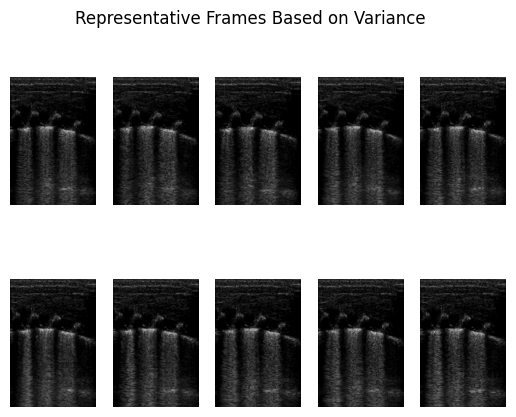

In [18]:
# show select_frames_1
for i, frame in enumerate(select_frames_1):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.suptitle('Representative Frames Based on Variance')
plt.show()

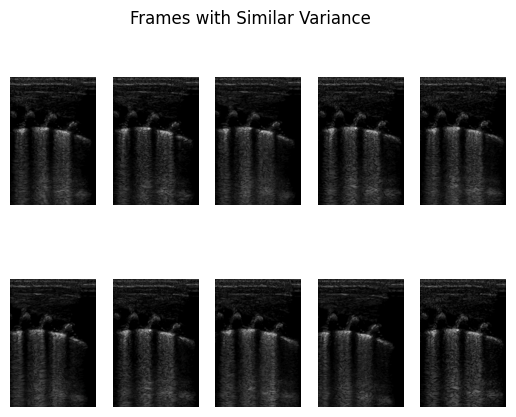

In [19]:
# show select_frames_2
for i, frame in enumerate(select_frames_2):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.suptitle('Frames with Similar Variance')
plt.show()

In [13]:
# select frames based on select_similar_variance_frames function for UHW videos
from collections import defaultdict
from tqdm import tqdm

input_dir = '/cosma5/data/durham/dc-fras4/ultrasound/output_frames/MFT'
output_dir = '/cosma5/data/durham/dc-fras4/ultrasound/output_frames/MFT/selected_frames'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Group files by Video ID first
video_groups = defaultdict(list)

for filename in os.listdir(input_dir):
    if filename.endswith('.png'):
        # Assuming filename format is "VIDEOID_frame_XXXX.png"
        video_id = filename.rsplit('_frame_', 1)[0]
        video_groups[video_id].append(filename)

# 2. Process each video group
for video_id, filenames in tqdm(video_groups.items(), desc="Processing videos"):
    all_video_frames = []
    
    # Load all frames for this specific video
    for filename in filenames:
        frame_path = os.path.join(input_dir, filename)
        frame = cv2.imread(frame_path)
        if frame is not None:
            all_video_frames.append(frame)
            
    # 3. Select frames
    if all_video_frames:
        selected_frames = select_similar_variance_frames(all_video_frames, num_frames=10)

        # 4. Save selected frames
        for i, frame in enumerate(selected_frames):
            frame_filename = os.path.join(output_dir, f"{video_id}_selected_frame_{i:04d}.png")
            cv2.imwrite(frame_filename, frame)

            

Processing videos: 100%|██████████| 1316/1316 [15:43<00:00,  1.39it/s]
